Import the dependencies

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from windrose import WindroseAxes
import matplotlib.cm as cm 

Load the datasets

In [2]:
df = pd.read_csv("../data/benin-malanville.csv")


1. Summary Statistics & Missing-Value Report

In [3]:
# Overview of numeric columns
print("The description of the numeric columns:")
print(df.describe())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the shape of the dataset")
print(df.info())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the first 5 rows")
print(df.head(5))
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the last 5 rows")
print(df.tail(5))

The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000

In [4]:
# Check for missing values
print("----------------------------------")
print("Check for missing values:")
print(f"{(df.isna().sum()/len(df)) * 100}%")

----------------------------------
Check for missing values:
Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: float64%


2. Outlier Detection & Basic Cleaning
- Cleaning strategy since we have found a missing value

In [5]:
# check if comments column is empty
# null_column = df['Comments'].isna().all()
# print(f"Is Comments fully null? {null_column}")

# Drop the Comments column since its empty
df.drop(columns=['Comments'], inplace=True)

# check
df.head(5)

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-08-09 00:01 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0     0.4   
1  2021-08-09 00:02 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.6  0.0     0.0   
2  2021-08-09 00:03 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.7  0.3     1.1   
3  2021-08-09 00:04 -1.1 -0.1 -1.0   0.0   0.0  26.2  93.3  0.2     0.7   
4  2021-08-09 00:05 -1.0 -0.1 -1.0   0.0   0.0  26.2  93.3  0.1     0.7   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  
0      0.1  122.1      0.0  998         0            0.0   26.3   26.2  
1      0.0    0.0      0.0  998         0            0.0   26.3   26.2  
2      0.5  124.6      1.5  997         0            0.0   26.4   26.2  
3      0.4  120.3      1.3  997         0            0.0   26.4   26.3  
4      0.3  113.2      1.0  997         0            0.0   26.4   26.3

Outlier detection


In [6]:
# # Identify numeric columns
# # Compute Z-scores and flag outliers (|Z| > 3)
numeric_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

# Compute Z-scores and flag outliers (|Z| > 3)
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_flags = (z_scores > 3).any(axis=1)
print(f"Number of outlier samples flagged: {outlier_flags.sum()}")

Number of outlier samples flagged: 7740


Imputation

In [7]:
# impute
for col in numeric_cols:
    df.loc[outlier_flags, col] = df[col].median()

#check for outliers
# Compute Z-scores and flag outliers (|Z| > 3)
numeric_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

# Compute Z-scores and flag outliers (|Z| > 3)
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_flags = (z_scores > 3).any(axis=1)
print(f"Number of outlier samples flagged: {outlier_flags.sum()}")

Number of outlier samples flagged: 3635


Export 

In [8]:
df_clean = df[~outlier_flags].copy() 
df_clean.to_csv("../data/benin_clean.csv", index=False)

4. Time Series Analysis

- Prepare Data  

In [9]:
# Convert 'Timestamp' to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Sort by time (critical for time series plots)
df = df.sort_index()

- Line Charts (Hourly/Daily Trends)

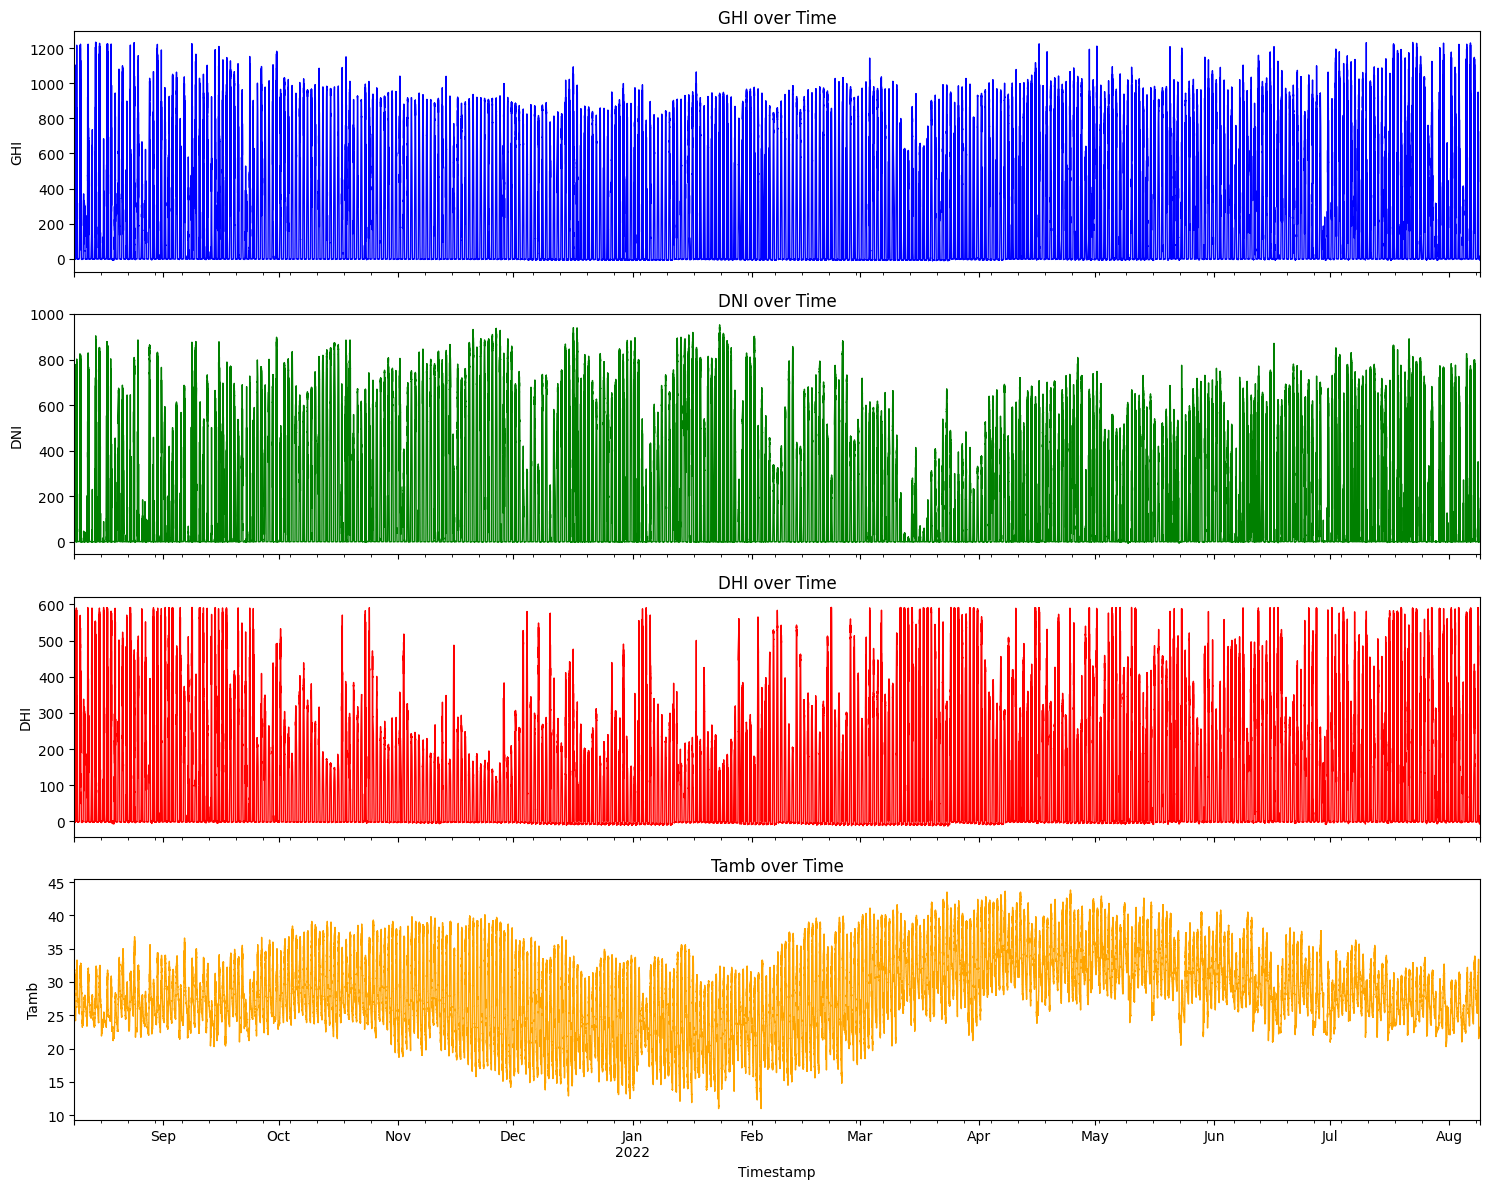

In [10]:
# Plot all 4 variables in subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

variables = ['GHI', 'DNI', 'DHI', 'Tamb']
colors = ['blue', 'green', 'red', 'orange']

for ax, var, color in zip(axes, variables, colors):
    df[var].plot(ax=ax, color=color, title=f'{var} over Time', lw=1)
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

- Monthly/Daily Averages

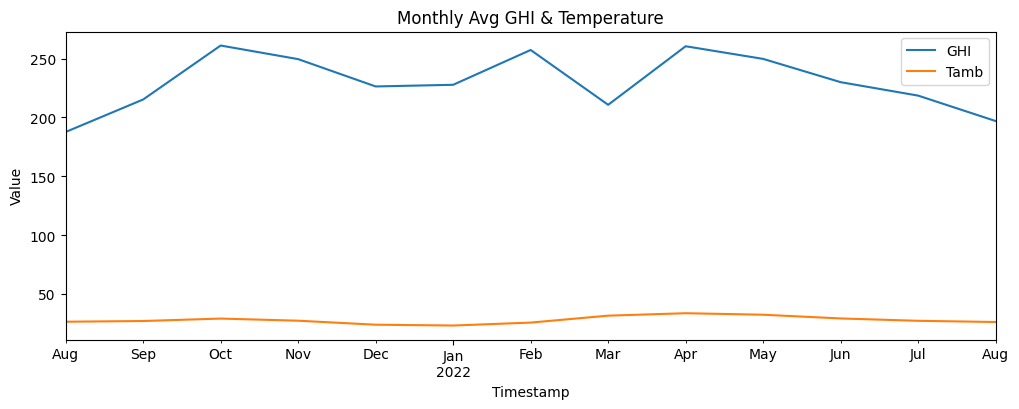

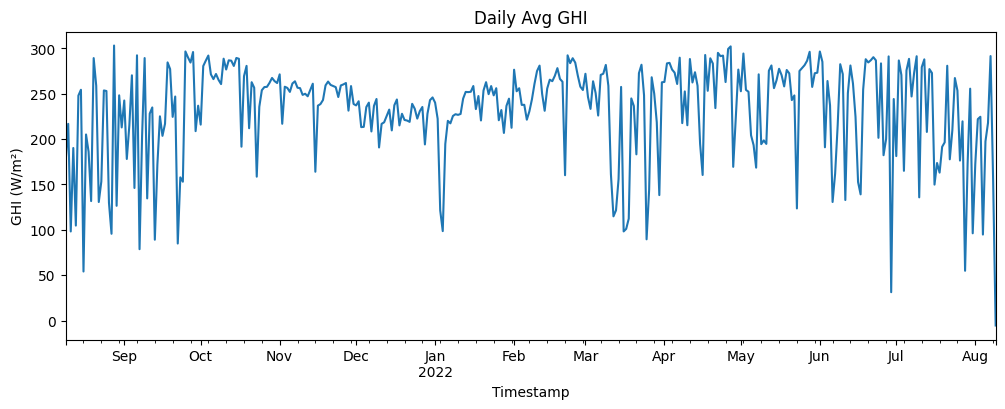

In [11]:
# Monthly averages
monthly = df.resample('ME').mean()
monthly[['GHI', 'Tamb']].plot(figsize=(12, 4), title='Monthly Avg GHI & Temperature')
plt.ylabel('Value')
plt.show()

# Daily averages (for hourly patterns)
daily = df.resample('D').mean()
daily['GHI'].plot(figsize=(12, 4), title='Daily Avg GHI')
plt.ylabel('GHI (W/m²)')
plt.show()

- Anomaly Detection

/home/abnsol/Documents/KAIM/solar-challenge-week1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/abnsol/Documents/KAIM/solar-challenge-week1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/abnsol/Documents/KAIM/solar-challenge-week1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


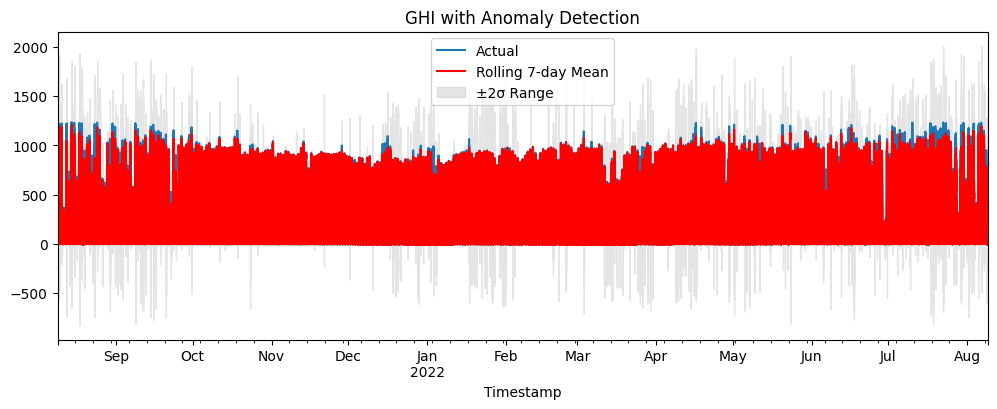

In [12]:
# Calculate rolling mean and std (7-day window)
window = 7  # days
rolling_mean = df['GHI'].rolling(window).mean()
rolling_std = df['GHI'].rolling(window).std()

# Plot with anomalies (values outside ±2σ)
plt.figure(figsize=(12, 4))
df['GHI'].plot(label='Actual')
rolling_mean.plot(label=f'Rolling {window}-day Mean', color='red')
plt.fill_between(
    df.index,
    rolling_mean - 2*rolling_std,
    rolling_mean + 2*rolling_std,
    color='gray', alpha=0.2, label='±2σ Range'
)
plt.title('GHI with Anomaly Detection')
plt.legend()
plt.show()

- Hourly Patterns (Boxplots by Hour)

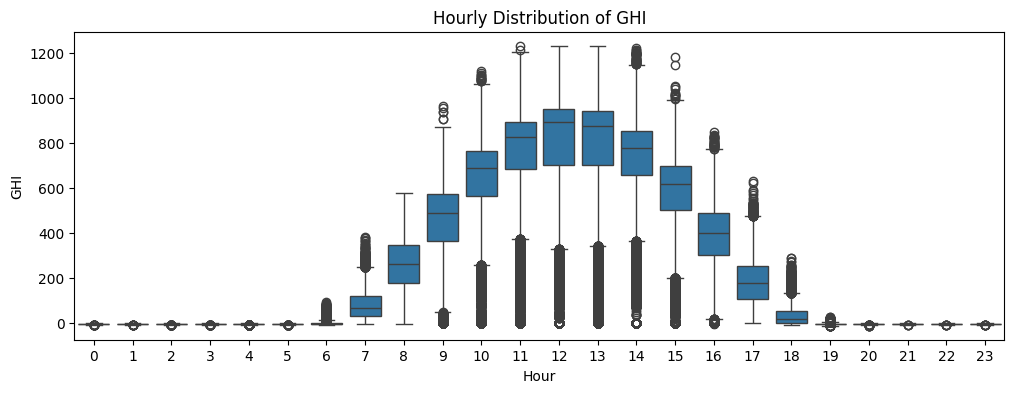

In [13]:
# Extract hour from Timestamp
df['Hour'] = df.index.hour

# Boxplot of GHI by hour
plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='Hour', y='GHI')
plt.title('Hourly Distribution of GHI')
plt.show()

5. Cleaning Impact

                     ModA        ModB
Cleaning_Flag                        
Post-Clean     226.105701  219.048329
Pre-Clean      236.589496  228.883576


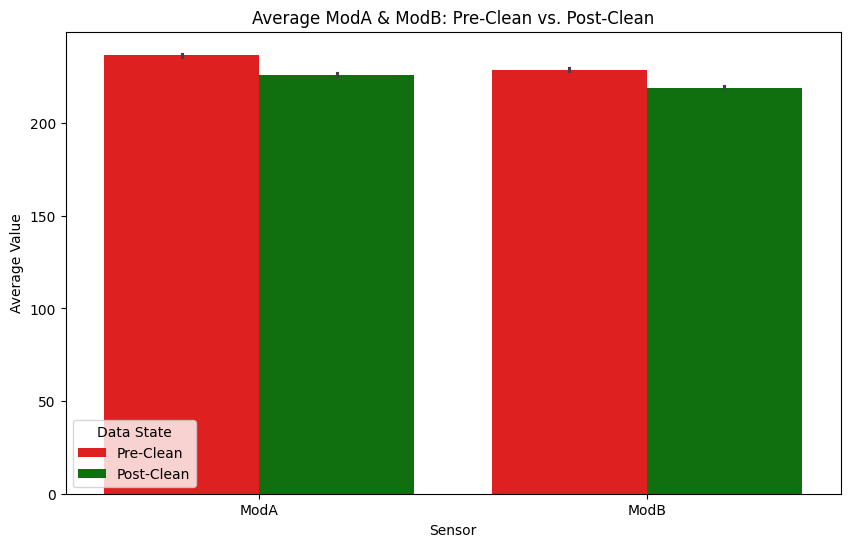

In [14]:
df_raw = pd.read_csv("../data/benin-malanville.csv")
df_new = pd.read_csv("../data/benin_clean.csv")

# Add flags
df_raw['Cleaning_Flag'] = 'Pre-Clean'
df_new['Cleaning_Flag'] = 'Post-Clean'

# Combine into one DataFrame for comparison
df_combined = pd.concat([df_raw, df_new])

# Group by flag and calculate mean
cleaning_impact = df_combined.groupby('Cleaning_Flag')[['ModA', 'ModB']].mean()
print(cleaning_impact)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_combined.melt(id_vars='Cleaning_Flag', value_vars=['ModA', 'ModB']),
    x='variable', 
    y='value', 
    hue='Cleaning_Flag',
    palette={'Pre-Clean': 'red', 'Post-Clean': 'green'}
)
plt.title('Average ModA & ModB: Pre-Clean vs. Post-Clean')
plt.ylabel('Average Value')
plt.xlabel('Sensor')
plt.legend(title='Data State')
plt.show()

6. Correlation & Relationship Analysis

- Correlation Heatmap

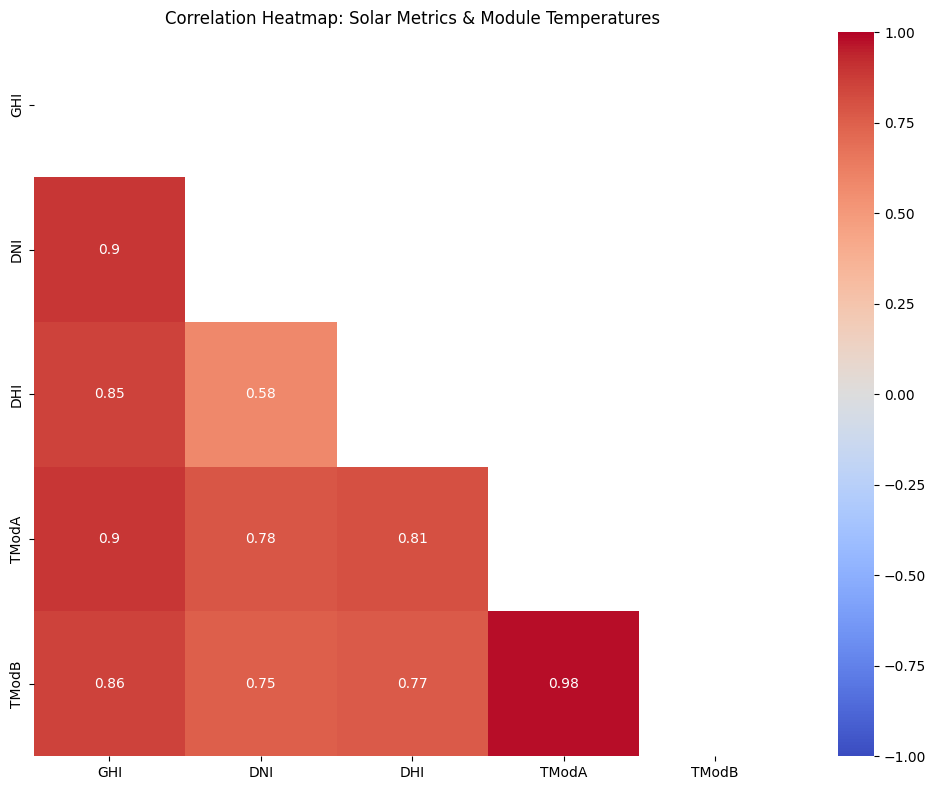

In [23]:
# Select columns for correlation
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df_clean[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,            # Show correlation values
    cmap='coolwarm',       # Red (positive) vs. Blue (negative)
    vmin=-1, vmax=1,       # Fix scale from -1 to 1
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show lower triangle only
)
plt.title('Correlation Heatmap: Solar Metrics & Module Temperatures')
plt.tight_layout()
plt.show()

Scatter Plots for Relationships

A. Wind vs. Solar Irradiance (WS, WSgust, WD vs. GHI)

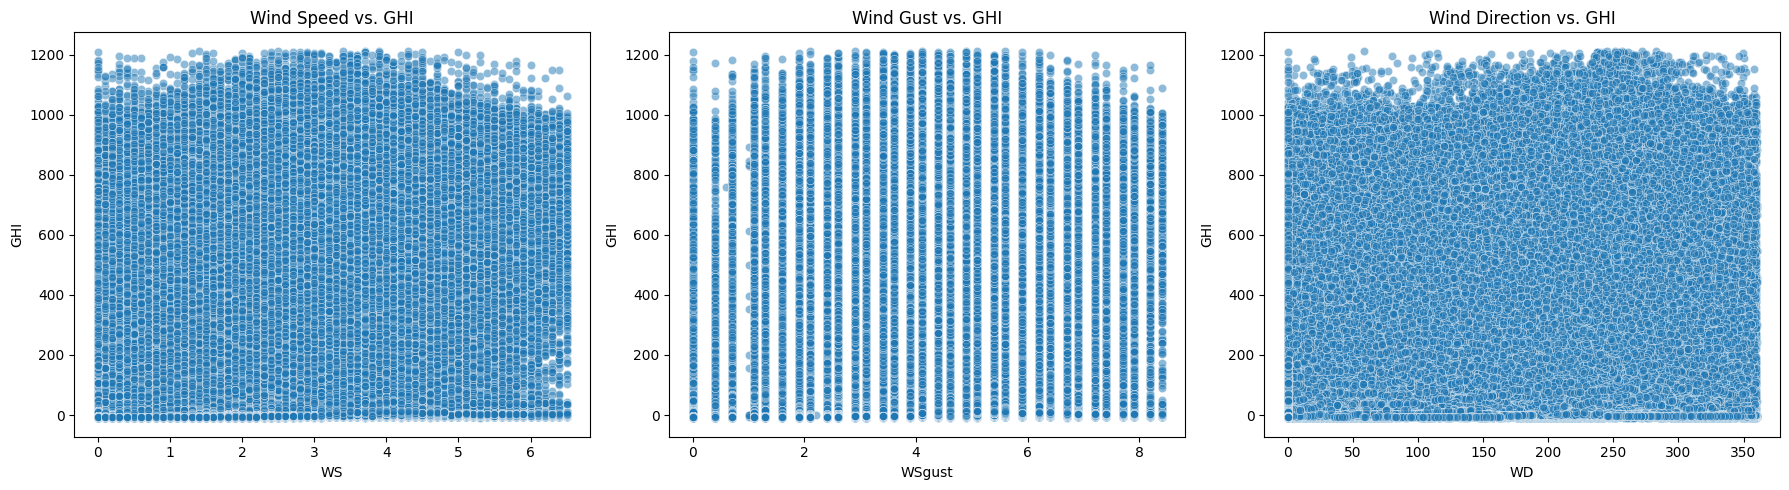

In [16]:
# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot WS vs. GHI
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axes[0], alpha=0.5)
axes[0].set_title('Wind Speed vs. GHI')

# Plot WSgust vs. GHI
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Wind Gust vs. GHI')

# Plot WD vs. GHI (Wind Direction)
sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axes[2], alpha=0.5)
axes[2].set_title('Wind Direction vs. GHI')

plt.tight_layout()
plt.show()

B. Humidity vs. Temperature/Radiation (RH vs. Tamb or GHI)

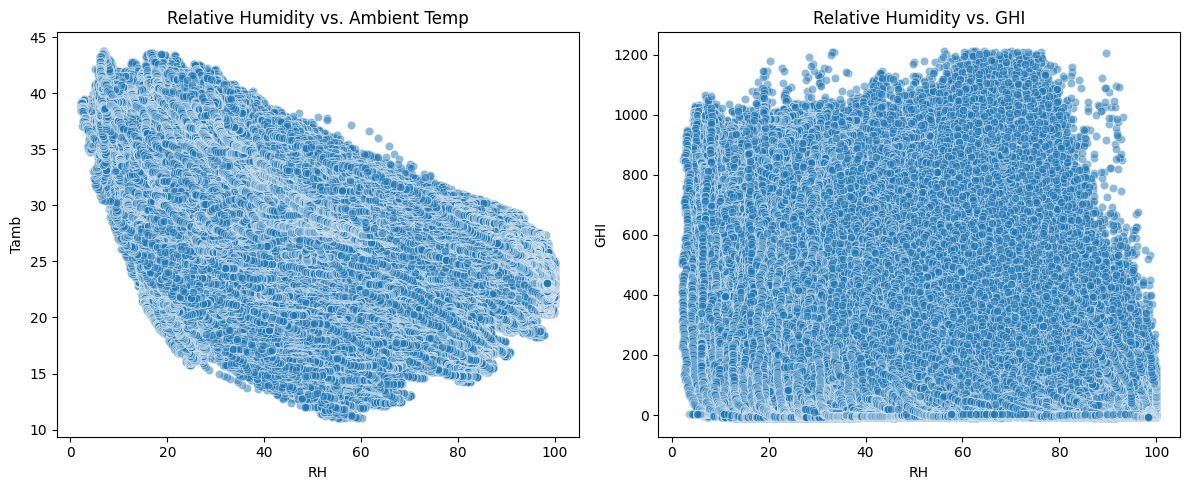

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RH vs. Tamb
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axes[0], alpha=0.5)
axes[0].set_title('Relative Humidity vs. Ambient Temp')

# RH vs. GHI
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=axes[1], alpha=0.5)
axes[1].set_title('Relative Humidity vs. GHI')

plt.tight_layout()
plt.show()

6. Wind & Distribution Analysis

- Wind rose or radial bar plot of WS/WD.

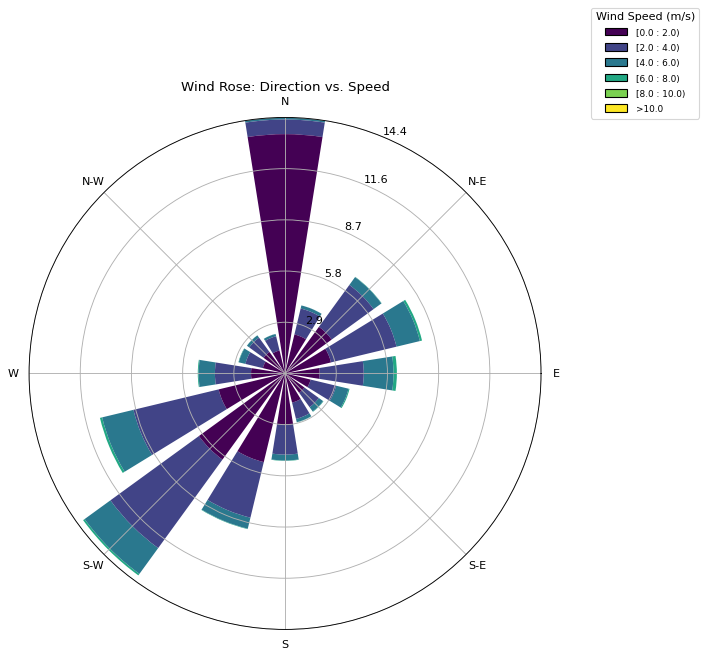

In [18]:
# Clean data
df_wind = df_clean[['WD', 'WS']].dropna()
df_wind['WD'] = df_wind['WD'].astype(float)  # Wind direction in degrees
df_wind['WS'] = df_wind['WS'].astype(float)  # Wind speed in m/s

# Create wind rose
ax = WindroseAxes.from_ax()
ax.bar(
    df_wind['WD'],              # Wind direction (degrees)
    df_wind['WS'],              # Wind speed (m/s)
    normed=True,                # Show percentages
    bins=np.arange(0, 12, 2),   # Speed bins: 0-2, 2-4, ..., 10-12 m/s
    cmap= cm.viridis             # Use cm.viridis, not 'viridis'
)
ax.set_legend(title='Wind Speed (m/s)', bbox_to_anchor=(1.1, 1))
plt.title('Wind Rose: Direction vs. Speed')
plt.show()

Histograms for GHI and one other variable (e.g. WS).

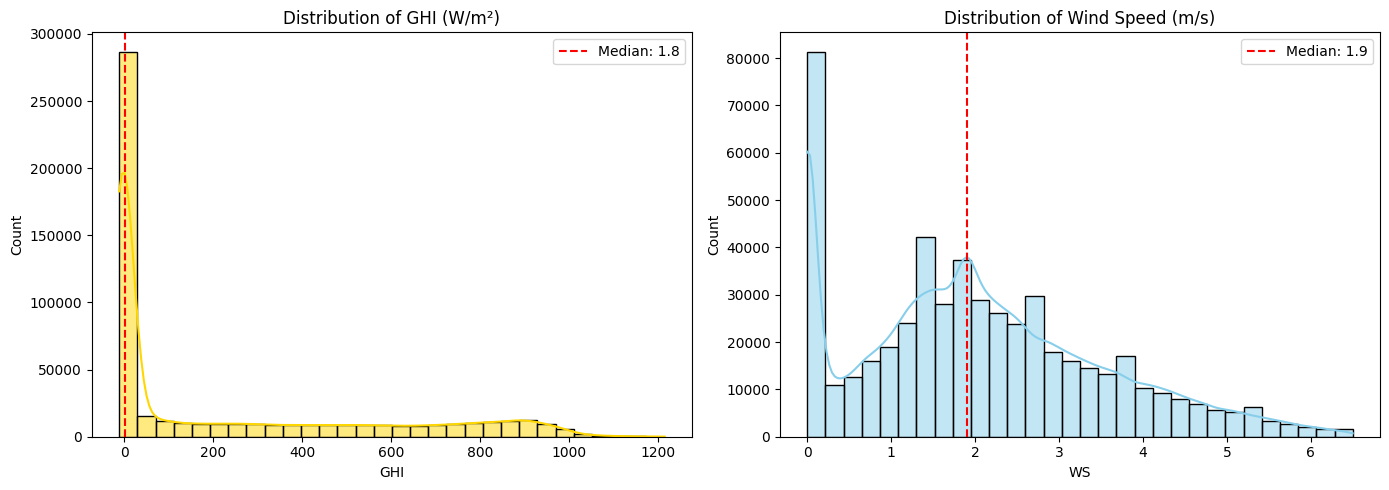

In [19]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for GHI (Global Horizontal Irradiance)
sns.histplot(
    data=df_clean,
    x='GHI',
    bins=30,
    kde=True,                # Kernel Density Estimate curve
    color='gold',
    ax=axes[0]
)
axes[0].set_title('Distribution of GHI (W/m²)')
axes[0].set_xlabel('GHI')
axes[0].axvline(df_clean['GHI'].median(), color='red', linestyle='--', label=f'Median: {df_clean["GHI"].median():.1f}')
axes[0].legend()

# Histogram for WS (Wind Speed)
sns.histplot(
    data=df_clean,
    x='WS',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[1]
)
axes[1].set_title('Distribution of Wind Speed (m/s)')
axes[1].set_xlabel('WS')
axes[1].axvline(df_clean['WS'].median(), color='red', linestyle='--', label=f'Median: {df_clean["WS"].median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

7. Temperature Analysis

1. Scatter Plot: RH vs. Tamb

<Axes: xlabel='RH', ylabel='Tamb'>

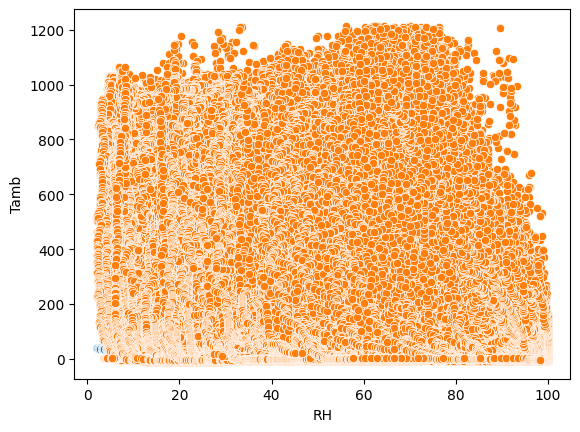

In [20]:
sns.scatterplot(data = df_clean, x = 'RH', y = 'Tamb')
sns.scatterplot(data = df_clean, x = 'RH', y = 'GHI')

8. Bubble Chart

1. Bubble Chart: GHI vs. Tamb (Bubble Size = RH)

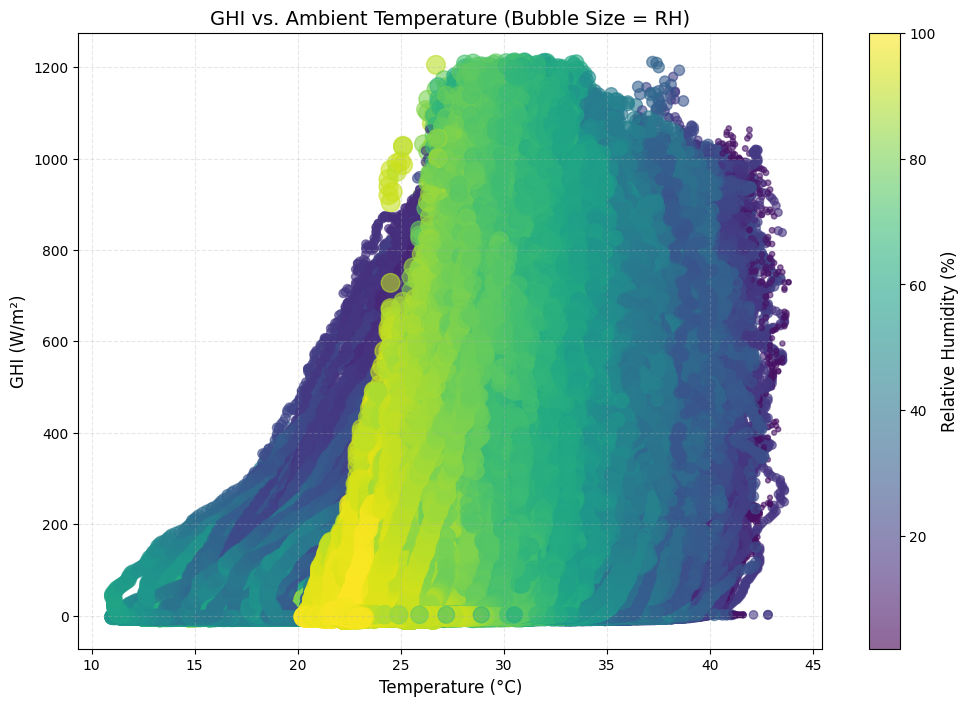

In [21]:
# Ensure data is clean and numeric
df_clean = df_clean.dropna(subset=['GHI', 'Tamb', 'RH'])  # Drop missing values
df_clean[['GHI', 'Tamb', 'RH']] = df_clean[['GHI', 'Tamb', 'RH']].apply(pd.to_numeric, errors='coerce')

# Create bubble chart
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=df_clean['Tamb'],
    y=df_clean['GHI'],
    s=df_clean['RH'] * 2,  # Scale RH for visibility (adjust multiplier as needed)
    c=df_clean['RH'],      # Color bubbles by RH
    alpha=0.6,
    cmap='viridis'
)

# Add labels and colorbar
plt.title('GHI vs. Ambient Temperature (Bubble Size = RH)', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('GHI (W/m²)', fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity (%)', fontsize=12)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

2. Bubble Chart: GHI vs. Tamb (Bubble Size = BP)

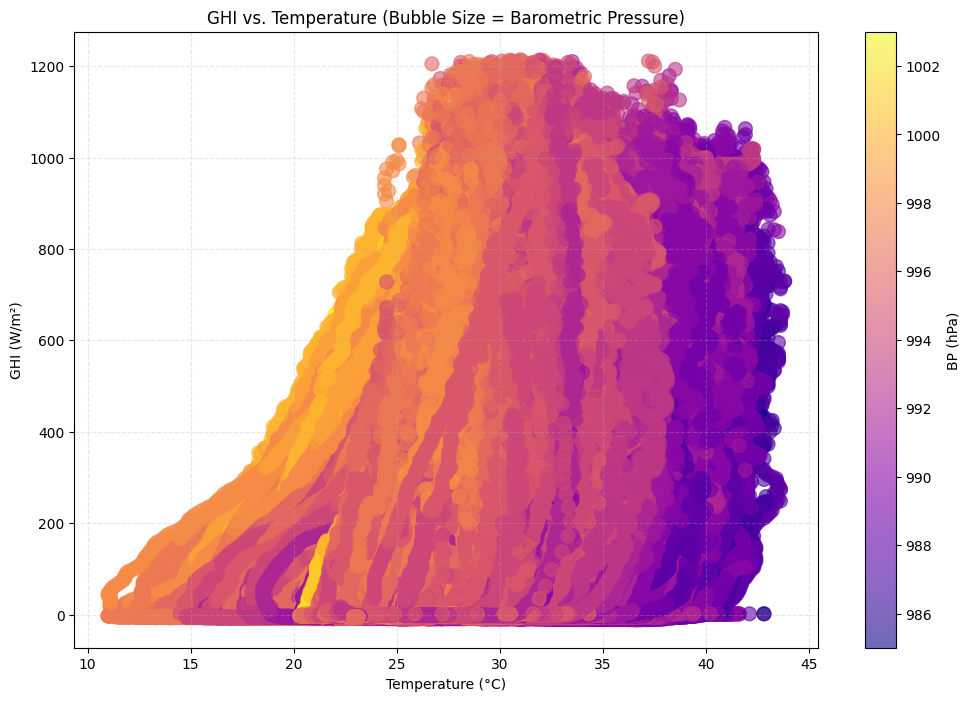

In [22]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=df_clean['Tamb'],
    y=df_clean['GHI'],
    s=df_clean['BP'] * 0.1,  # Scale BP appropriately
    c=df_clean['BP'],
    alpha=0.6,
    cmap='plasma'            # Different colormap for clarity
)
plt.title('GHI vs. Temperature (Bubble Size = Barometric Pressure)')
plt.xlabel('Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.colorbar(label='BP (hPa)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()